In [2]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/ccpg44dt73ga24p45a0u3/collaborations_Zoology_608.csv.gz?rlkey=8kr35ztwfztz36qww7v1fr926&st=xcxd6s6d&dl=1',
        compression='gzip',
    )

,article_id,year,researcher_id
0,pub.1100184428,2018.0,ur.07500112735.28
1,pub.1100184428,2018.0,ur.0775274140.76
2,pub.1014429482,2008.0,ur.012645135765.17
3,pub.1014429482,2008.0,ur.016413706041.84
4,pub.1071171019,1994.0,ur.01216432663.31
...,...,...,...
1134648,pub.1028766873,2008.0,ur.0747722674.67
1134649,pub.1063382447,2016.0,ur.01114402740.30
1134650,pub.1063382447,2016.0,ur.01137537003.00
1134651,pub.1063382447,2016.0,ur.0577704134.35


In [4]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/0bsgnsgb1rr1s143cgyd1/articles_Zoology_608.csv.gz?rlkey=emlv5fy52dz0d2rnodygjy9pp&st=kehlrig7&dl=1',
        compression = 'gzip',
    ).columns

/var/folders/v9/_js75nzx64lf8__fmfsscg4c0000gn/T/ipykernel_1470/2360218702.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,12,20) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


Index(['article_id', 'year', 'date', 'doi', 'volume', 'issue', 'pages',
       'title_preferred', 'abstract_preferred', 'journal_title',
       'citations_count', 'metrics_times_cited', 'metrics_recent_citations',
       'metrics_field_citation_ratio', 'metrics_relative_citation_ratio',
       'altmetrics_score', 'nauthors', 'npatents_citing',
       'ncategory_for_l1_codes', 'ncategory_for_l2_codes',
       'pg_abstract_preferred_lang_code', 'pg_abstract_preferred_lang_conf'],
      dtype='object')

In [5]:
# load the data
df = pd.read_csv(
        'https://www.dropbox.com/scl/fi/a1t16rtialcw03n50ffkc/concepts_Zoology_608.csv.gz?rlkey=vjv60sfbhofbgvzfzdkrlurl1&st=ciu77f72&dl=1',
        compression='gzip',
    )

df

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1050083629,1984,mfvsg,0.0,1,0,2,1
1,pub.1050083629,1984,svsg,0.0,1,1,1,1
2,pub.1091469564,1992,1972 random parasitoid model,0.0,1,0,1,1
3,pub.1117742847,2001,198697 lobster research cruise,0.0,1,0,1,1
4,pub.1043257859,2001,1986–97 lobster research cruise,0.0,1,0,2,2
...,...,...,...,...,...,...,...,...
18064866,pub.1000238039,2015,’s worker population size,0.0,1,40,1,1
18064867,pub.1005449634,2012,’s workforce swarm fraction depart,0.0,1,42,1,1
18064868,pub.1134463678,2021,’s bad crop pest,0.0,1,57,1,1
18064869,pub.1083920773,2017,’s bad invasive,0.0,1,54,1,1


In [6]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
18622,pub.1039451177,akh receptor,2002
18623,pub.1129686695,akh receptor,2020
18624,pub.1007326462,akh receptor,2006
18625,pub.1101015253,akh receptor,2018
49772,pub.1092160858,acromyrmex leaf cut ant,2017
...,...,...,...
18063221,pub.1010904311,γδ t cell,2012
18063223,pub.1039368032,γδ t cell,2014
18063225,pub.1120146611,γδ t cell,2019
18063226,pub.1040144066,γδ t cell,2012


In [7]:
# get the last publication
concepts = (
    df
        .sort_values('year')
        .drop_duplicates(subset='concept', keep='first')
        .reset_index(drop=True)
)
# normalize the year
concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
print(concepts)

          article_id                        concept  year  norm_year
0     pub.1070547478                      land bird  1920   0.000000
1     pub.1005636163                     fruit tree  1921   0.009901
2     pub.1070548561                american museum  1922   0.019802
3     pub.1070548072              bird conservation  1922   0.019802
4     pub.1054807332        ministry of agriculture  1923   0.029703
...              ...                            ...   ...        ...
4141  pub.1122800167    free plain language summary  2019   0.980198
4142  pub.1112852989  sustainable development goals  2019   0.980198
4143  pub.1125125078     invasive non native specie  2020   0.990099
4144  pub.1131427185               student learning  2020   0.990099
4145  pub.1125090234    hermetic storage technology  2020   0.990099

[4146 rows x 4 columns]


## Network Edges
Get the edges of the network by merging the dataframe in on itself. Then, we again keep only the first occurrence and normalize the year.

In [8]:
# get all possible edges
edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])

# remove duplicates
edges = edges[edges['concept_source'] < edges['concept_target']]  # remove self links (u - u) and the second occurance (u - v vs v - u)
edges = edges.sort_values('year').drop_duplicates(subset=['concept_source', 'concept_target']).reset_index(drop=True)

# nromalize the year
edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

edges

,article_id,concept_source,year,concept_target,norm_year
0,pub.1014736377,crop production,1923,field crop,0.029703
1,pub.1029501515,british museum expedition,1923,museum expedition,0.029703
2,pub.1054807062,english channel,1925,oceanic water,0.049505
3,pub.1054807182,english channel,1925,inshore water,0.049505
4,pub.1054807182,deep water,1925,inshore water,0.049505
...,...,...,...,...,...
22851,pub.1135822847,aphid species,2021,field experiment,1.000000
22852,pub.1136270513,common ancestor,2021,filter feed larvae,1.000000
22853,pub.1137711773,bt toxin cry1ac,2021,resistance management strategy,1.000000
22854,pub.1138164980,field population,2021,wild population,1.000000


In [9]:
# initialize the graph
G = nx.Graph()

# add the nodes
G.add_nodes_from([(c, {'weight': ny}) for c, ny in zip(concepts['concept'], concepts['norm_year'])])


# add the edges
G.add_edges_from([(u, v, {'weight': ny}) for u, v, ny in zip(edges['concept_source'], edges['concept_target'], edges['norm_year'])])

G

In [1]:
pip install scipy==1.10.1

Note: you may need to restart the kernel to use updated packages.


In [10]:
import networkx as nx
import random
from gensim.models import Word2Vec
from scipy.cluster.hierarchy import dendrogram, linkage

def random_walk(graph, start_node, walk_length):
  if start_node not in graph:
    raise ValueError("The start node must be in the graph.")
  walk = [start_node]
  current_node = start_node
  for _ in range(walk_length):
    neighbors = list(graph.neighbors(current_node))
    if neighbors:  # make sure the node has neighbors
      current_node = random.choice(neighbors)
      walk.append(current_node)
    else:  # if there are no neighbors the walk ends
      break
  return walk
def generate_random_walks(graph, nwalks, walk_length):
  walks = []
  for _ in range(nwalks):
    for node in graph.nodes():
      walks.append(random_walk(graph, node, walk_length))
  return [[str(node) for node in walk] for walk in walks] 

In [11]:
random_walks = generate_random_walks(G, 
                                     nwalks=10, 
                                     walk_length=5)

In [12]:
model = Word2Vec(sentences=random_walks, 
                 vector_size=30, 
                 window=5, 
                 min_count=0, 
                 sg=1, 
                 workers=4,
                 negative=15)

In [13]:
labels = list(model.wv.index_to_key)
vectors = [model.wv[node] for node in labels]

In [14]:
Z = linkage(vectors, "ward")

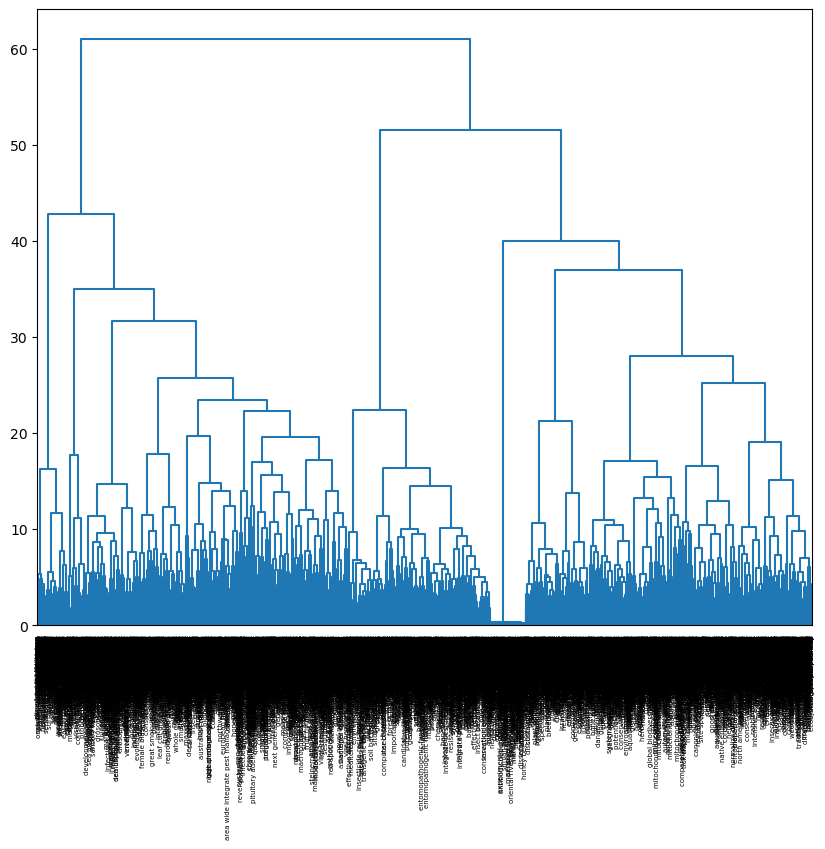

In [17]:
# plot the results
plt.figure(figsize=(10, 8))

# plot the dendrogam
dendrogram(Z, 
           labels=labels, 
           orientation="top", 
           color_threshold=0)

# color clubs
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()

plt.show()